### Libs & Data

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
import random
import unicodedata
from string import punctuation
from string import digits
from nltk.stem import WordNetLemmatizer
import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import torch
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

import spacy
from spacy.matcher import Matcher

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwsst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kwsst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("data/df_park.csv")
df.shape

(5324, 9)

In [4]:
df.head()

,Unnamed: 0,title,author,time,description,body,section,summarized_body,agg_title_body
0,1,[Weekender] Korea’s dynamic 2017,Choi He-suk,2018-01-01 13:22:00,From North Korea’s nuclear weapons program nea...,From North Korea’s nuclear weapons program nea...,Social affairs,The corruption scandal that broke out in 2016 ...,[Weekender] Korea’s dynamic 2017. From North K...
1,13,Headline makers of 2017,Korea Herald,2017-12-29 16:42:00,Moon Jae-inPresident Moon Jae-in (Yonhap)Moon ...,Moon Jae-inPresident Moon Jae-in (Yonhap)Moon ...,Social affairs,South Korean President Moon Jae-in rose to bec...,Headline makers of 2017. Moon Jae-inPresident ...
2,16,"Moon pardons 6,444 people, excluding business ...",Ock Hyun-ju,2017-12-29 16:01:00,"President Moon Jae-in granted pardons to 6,444...","President Moon Jae-in granted pardons to 6,444...",Social affairs,"President Moon Jae-in granted pardons to 6,444...","Moon pardons 6,444 people, excluding business ..."
3,19,Businessmen call for probe into shutdown of fa...,Yonhap,2017-12-29 15:04:00,A private task force on Friday pressed the gov...,A private task force on Friday pressed the gov...,North Korea,South Korea pulled the plug on the factory par...,Businessmen call for probe into shutdown of fa...
4,21,Special pardons aimed at helping ordinary peop...,Yonhap,2017-12-29 11:39:00,"The latest pardon extended to more than 6,000 ...","The latest pardon extended to more than 6,000 ...",Politics,"The latest pardon extended to more than 6,000 ...",Special pardons aimed at helping ordinary peop...


### Import the embedded documents

In [5]:
vects = joblib.load('data/tfidf_titlebody_park.csv')
vects.shape

(5324, 300)

### Clustering

In [8]:
### Clustering 
def document_clustering(doc_vectors, clustering_method='kmeans', evaluate=False):
    if clustering_method=='kmeans':
        # Hyperparameters
        k_event = 10000
        k_issue = 6000
        
        # Clustering event
        kmeans_event = KMeans(n_clusters=k_event, random_state=69).fit(doc_vectors)
        # Represent each event by average sum of related news
        event_vectors = np.zeros((k_event, doc_vectors.shape[1]))
        for i in range(k_event):
            event_vectors[i] = sum(doc_vectors[kmeans_event.labels_ == i])
        
        # Clustering issue
        kmeans_issue = KMeans(n_clusters=k_issue, random_state=69).fit(event_vectors)
        # Represent each issue by average sum of related news
        issue_vectors = np.zeros((k_issue, doc_vectors.shape[1]))
        for i in range(k_issue):
            issue_vectors[i] = sum(event_vectors[kmeans_issue.labels_ == i])

        issue_labels = np.array([ kmeans_issue.labels_[kmeans_event.labels_[i]] for i in range(doc_vectors.shape[0]) ])
        
        return k_issue, k_event, issue_labels, kmeans_event.labels_
    
    elif clustering_method=='DBSCAN':
        
        # Hyperparameters
        doc_eps = 0.255
        doc_neighbors = 1
        event_eps = 0.40
        event_neighbors = 1
        
        '''
            Find best doc_eps and event_eps
        '''
        if evaluate:
            # Find best eps to group same document
            doc_eps_list = [ 0.2 + 0.001*i for i in range(1,1001) ]
            doc_score = []
            doc_event = []
            doc_best_score = 0
            doc_best_eps = 0.0001
            for doc_eps in doc_eps_list:
                # Clustering event
                db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
                # Number of clusters in labels, ignoring noise if present.
                n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
                if len(set(db_event.labels_)) >= 2 and len(set(db_event.labels_)) <= len(doc_vectors)-1:
                    score_ = silhouette_score(doc_vectors, db_event.labels_)
                else:
                    score_ = -1
                doc_event.append(n_events_)
                doc_score.append(score_)
                if score_ > doc_best_score:
                    doc_best_score = score_
                    doc_best_eps = doc_eps
            print("Best Silhouete score is {} at eps: {} and number of events: {}".format(doc_best_score, doc_eps, n_events_))
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_score)
            fig.suptitle('Doc eps and Silhouette score', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('Silhouette score', fontsize=16)
            plt.show()
            
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_event)
            fig.suptitle('Doc eps and number of events', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('number of events', fontsize=16)
            plt.show()
            
            # Set doc_eps to the best value
            doc_eps = doc_best_eps
            # Find best eps to group same event
            # Clustering event
            db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)
            
            # Clustering issue
            event_eps_list = [ 0.2 + 0.001*i for i in range(1,1001) ]
            event_score = []
            event_issue = []
            event_best_score = 0
            event_best_eps = 0.001
            for event_eps in event_eps_list:
                db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
                # Number of clusters in labels, ignoring noise if present.
                n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
                if len(set(db_issue.labels_)) >= 2 and len(set(db_issue.labels_)) <= len(event_vectors)-1:
                    score_ = silhouette_score(event_vectors, db_issue.labels_)
                else:
                    score_ = -1
                event_issue.append(n_issues_)
                event_score.append(score_)
                if score_ > event_best_score:
                    event_best_score = score_
                    event_best_eps = event_eps
            print("Best Silhouete score is {} at eps: {} and number of issues: {}".format(event_best_score, event_eps, n_issues_))
            fig = plt.figure()
            plt.plot(event_eps_list, event_score)
            fig.suptitle('Event eps and Silhouette score', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('Silhouette score', fontsize=16)
            plt.show()
            
            fig = plt.figure()
            plt.plot(event_eps_list, event_issue)
            fig.suptitle('Event eps and number of issues', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('number of issues', fontsize=16)
            plt.show()
            
            # Set event_eps to best value
            event_eps = event_best_eps
            # Clustering issue
            db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            print(n_issues_, n_noise_)
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
       
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        else:
            '''
            Clustering using specific value
            '''
            # Clustering event
            db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            n_noise_ = list(db_event.labels_).count(-1)
            print(n_events_, n_noise_)
            # Represent each event by average sum of related news
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)

            # Clustering issue
            db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            print(n_issues_, n_noise_)
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
        
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        return n_issues_, n_events_, issue_labels, event_labels
    
    elif clustering_method=='agglomerative':
        
        pass
    
    elif clustering_method=='LDA':
        
        pass
    
    else:
        assert("Doesn't support {}".format(clustering_method))

Best Silhouete score is 0.08860119834279026 at eps: 1.2 and number of events: 1


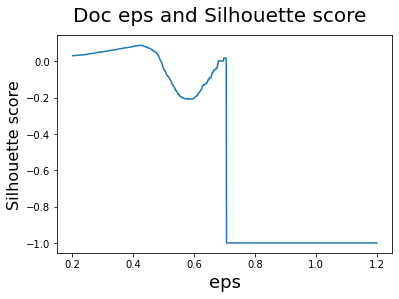

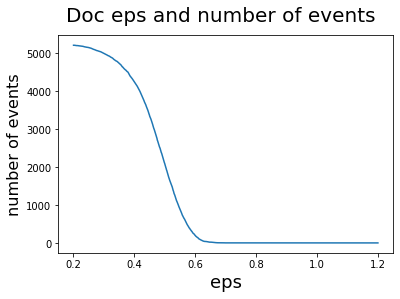

Best Silhouete score is 0.03024189954905668 at eps: 1.2 and number of issues: 1


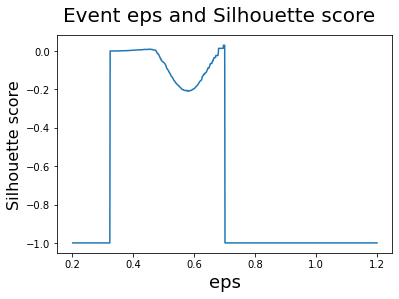

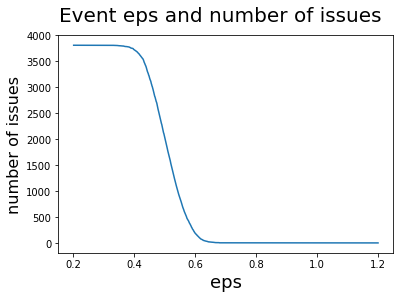

2 0


In [9]:
num_issue, num_event, issue_labels, event_labels = document_clustering(vects,
                                                                       clustering_method='DBSCAN',
                                                                       evaluate=True)

In [10]:
num_issue, num_event, issue_labels, event_labels = document_clustering(vects,
                                                                       clustering_method='DBSCAN',
                                                                       evaluate=False)

5140 0
4256 0


In [11]:
df['label'] = event_labels
df.head()

,Unnamed: 0,title,author,time,description,body,section,summarized_body,agg_title_body,label
0,1,[Weekender] Korea’s dynamic 2017,Choi He-suk,2018-01-01 13:22:00,From North Korea’s nuclear weapons program nea...,From North Korea’s nuclear weapons program nea...,Social affairs,The corruption scandal that broke out in 2016 ...,[Weekender] Korea’s dynamic 2017. From North K...,0
1,13,Headline makers of 2017,Korea Herald,2017-12-29 16:42:00,Moon Jae-inPresident Moon Jae-in (Yonhap)Moon ...,Moon Jae-inPresident Moon Jae-in (Yonhap)Moon ...,Social affairs,South Korean President Moon Jae-in rose to bec...,Headline makers of 2017. Moon Jae-inPresident ...,1
2,16,"Moon pardons 6,444 people, excluding business ...",Ock Hyun-ju,2017-12-29 16:01:00,"President Moon Jae-in granted pardons to 6,444...","President Moon Jae-in granted pardons to 6,444...",Social affairs,"President Moon Jae-in granted pardons to 6,444...","Moon pardons 6,444 people, excluding business ...",2
3,19,Businessmen call for probe into shutdown of fa...,Yonhap,2017-12-29 15:04:00,A private task force on Friday pressed the gov...,A private task force on Friday pressed the gov...,North Korea,South Korea pulled the plug on the factory par...,Businessmen call for probe into shutdown of fa...,3
4,21,Special pardons aimed at helping ordinary peop...,Yonhap,2017-12-29 11:39:00,"The latest pardon extended to more than 6,000 ...","The latest pardon extended to more than 6,000 ...",Politics,"The latest pardon extended to more than 6,000 ...",Special pardons aimed at helping ordinary peop...,4


In [16]:
# get top n most frequent labels
n = 10
label = df['label'].value_counts()[:n].index.tolist()
label

[3655, 4774, 4254, 1196, 4590, 1945, 3015, 4299, 3596, 919]

In [17]:
def freq_label(df, labels):
    freqs = []
    for label in labels:
        freq = df.loc[df.label == label, 'label'].count()
        freqs.append(freq)
    return freqs
freq_label(df, label)

[5, 4, 4, 4, 3, 3, 3, 3, 3, 3]

In [18]:
# Concat the sentences in each group and make a summary
summary = []
for i in label:
    s = ''
    for sentence in df[df['label'] == i]['summarized_body'].tolist():
        s += sentence
    summary.append(s)
len(summary)

10

In [19]:
summary

['Prime Minister Hwang Kyo-ahn announced Tuesday that South Korea would officially reinstate government-issued history textbooks for secondary education from 2017. He said that the current system had failed after four years of implementation. The main opposition New Politics Alliance for Democracy boycotted the plenary session of the National Assembly to protest the government’s decision.The Education Ministry recently announced that it will take back publishing rights of history textbooks for secondary education. A history professor with experience authoring a state-published textbook said granting the government exclusive rights to write textbooks is among the worst idea imaginable. He voiced concerns that state-authored books will attempt to favorably depict controversial figures like former President Park Chung-hee.The government said it will rule out “far-right” scholars as authors. The government is planning to revive state-authored history textbooks. There are concerns that they

In [20]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [21]:
def summarize_text(s: str):
    inputs = tokenizer([s], max_length=1024, return_tensors='pt', truncation=True).to(device)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=100, early_stopping=True)
    output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    torch.cuda.empty_cache()
    return output[0]

In [22]:
for i in range(len(summary)):
    summary[i] = summarize_text(summary[i])
summary[:5]

['Prime Minister Hwang Kyo-ahn announced Tuesday that South Korea would officially reinstate government-issued history textbooks for secondary education from 2017. He said that the current system had failed after four years of implementation. The main opposition New Politics Alliance for Democracy boycotted the plenary session of the National Assembly to protest the government’s decision.',
 'Seoul-Tokyo ties have plunged to lowest levels in recent years mainly due to the sex slavery issue. Historians estimate the number of sex slaves at about 200,000 with only 53 South Korean victims alive today. Japan angered Seoul and Beijing by saying that its 1993 apology was the outcome of a political compromise.',
 'President Park Geun-hye’s flagship education policy of “half-price” college tuition is facing skepticism. Experts say the lack of long-term financial resources to sustain it. Most major colleges nationwide have announced, or plan, a tuition freeze for this year.',
 'Munmyeong High Sc

In [25]:
# Export to csv
topnsum = pd.DataFrame(summary, columns=['summary'])
topnsum['label'] = label
topnsum['freq'] = freq_label(df, label)
topnsum

,summary,label,freq
0,Prime Minister Hwang Kyo-ahn announced Tuesday...,3655,5
1,Seoul-Tokyo ties have plunged to lowest levels...,4774,4
2,President Park Geun-hye’s flagship education p...,4254,4
3,"Munmyeong High School in Gyeongsan, 331 kilome...",1196,4
4,President Park Geun-hye attended a rollout cer...,4590,3
5,Some 1.7 million people gathered in central Se...,1945,3
6,South Korea and Mexico agree to hold working-l...,3015,3
7,Foreign Minister Yun Byung-se began his two-da...,4299,3
8,"120,000 tons of Russian coal will be delivered...",3596,3
9,Six pieces of bones were found on the deck of ...,919,3
